# Trained Model Performance Analysis
## Introduction
After a model has been trained and before it can be leveraged in production, it must be tested. This testing process typically takes the form of:

1. **Analyzing the results from the training porocess:**  
    A good indication that the model performs well on the training data is to verify that the overall
    *Training Error* (Cost Function) decreases after every iteration of the forward propogation process.
    If after the final epoch, the error is less than $0.01$, this generally shows that the training has 
    been successful.
2. **Predicting against a test data set:**  
    A good portice in machine learning is to create a subset of the training data keep it separate for testing.
    This is typically refered to as a *hold-out*, *validation* or *test* set. By testing how well the model performans against this data, 
    further insight can be derived.
3. **Predicting against previously unseen data:**  
    Testing the model against an image that is neither part of the training data or the testing will provide realistic proof
    of it's performance in production.

The following notebook demonstartes how the trainedl model performs against the above testing methodolody.

---
## 1 - Analyzing the Results from the Training Process
### Training Output Files
Before the analysis can begin, the appropriate data from the training process needs to be collected from the S3 bucket that
was created during the deployment. These are:
- **Results:** After training is complete the **SNN* outputs the training error for each epoch to a JSON (`results.json`)file.
- **Model Configuration:** The network model parameters file (`parameters.json`).
- **Optmized/Trained Parameters:** The final **Weights** and **Bias** parameters that have been optmized by the **Gradient Descent**
    process.

The following code cells extracts the above data sets from S3. To start, please enter the name of the S3 Bucket created during the
deployment process as well as the AWS Region used.

In [1]:
# Enter the S3 Bucket Name and Region used during deployment
#S3_bucket = <<Bucket Name>>
#rgn = <<AWS Region>>
S3_Bucket = 'lnn-030-tmp'
rgn = 'us-east-1'

In [2]:
# Import Libraries and training results data
from Utils import *

# Training results
results_content = s3_resource.Object(S3_Bucket, 'training_results/results.json')
results_file = results_content.get()['Body'].read().decode('utf-8')
results = loads(results_file)

# Model parameters
parameters_content = s3_resource.Object(S3_Bucket, 'training_input/parameters.json')
parameters_file = parameters_content.get()['Body'].read().decode('utf-8')
NN_parameters = loads(parameters_file)

# Trained/Optimized parameters
input_bucket = s3_resource.Bucket(S3_Bucket)
input_bucket.download_file('predict_input/params.h5', '/tmp/params.h5')
with h5py.File('/tmp/params.h5', 'r') as h5file:
    trained_parameters = {}
    for key, item in h5file['/'].items():
        trained_parameters[key] = item.value

### Training Results
Now that all of the relevent data has been collected from S3, a similar exercise to the $10$ epoch sample used in the 
[codebook](./Codebook.ipynb) can be done on the final results.

Total Processing time: 49 Hours
Final Cost: 0.07360810617779764


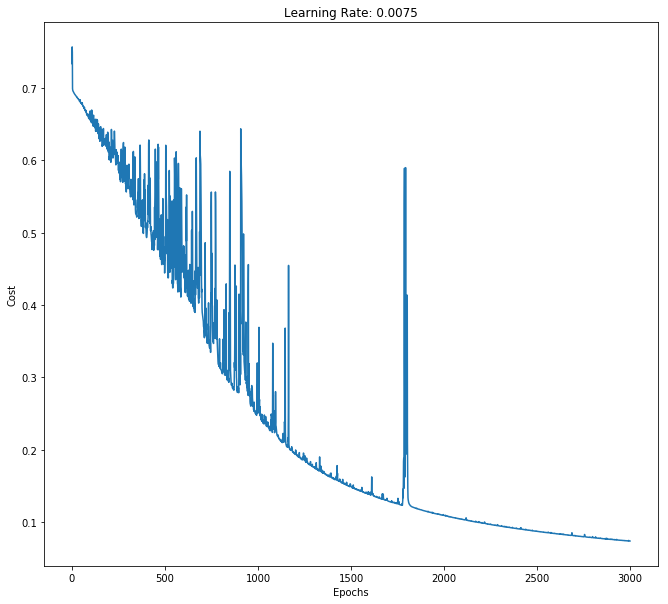

In [3]:
# Training Results Overview
%matplotlib inline
plt.rcParams['figure.figsize'] = (11.0, 10.0)
costs = []
for k, v in results.items():
    # Get the cost at each epoch
    if 'epoch' in k:
        costs.append(v.get('cost'))
    # Get the training start time
    elif 'Start' in k:
        start = datetime.datetime.strptime(v, "%Y-%m-%d %H:%M:%S.%f")
    # Get the training end time
    else:
        end = datetime.datetime.strptime(v, "%Y-%m-%d %H:%M:%S.%f")
delta = end - start
print("Total Processing time: {} Hours".format(int(delta.total_seconds() / 60 /60)))
print("Final Cost: {}".format(results.get('epoch' + str(NN_parameters['epochs']-1))['cost']))
# Plot the results
plt.plot(costs)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.title("Learning Rate: " + str(NN_parameters['learning_rate']))
plt.show;

---
## 2 - Predicting against a Test Data Set
### Load and Pre-process the Test Data
The data used for testing and validation is exatly the same as the data used for traing save for the fact that there are less examples, $50$ as opposed to $209$.

In [4]:
# Load test dataset
test_set_x_orig, Y, classes = load_data()
num_px = test_set_x_orig.shape[1]

Just as with the training set, the test set images need to be pre-processed as the model is expecting a numpy array
of shape (no. pixels $\times$ no. pixels $\times$ depth, data set size). Additionally the model also expects the
testing labels to be a vector of shape (1, data set size).

In [5]:
# Reshape testing data to a matrix of volum vectors
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

# Standardize the data to have features between 0 and 1
X = test_x_flatten / 255

### Testing Results
#### Classification Accuracy Score
One of the most comman evaluation metrics used for classification models in the **Accuracy Score** and generally summarizes the number of correct predictions the classifier has made as a ratio of all the predictions.

In [6]:
# Accuracy Score
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
Y = list(Y.flat)
# Run the model agains the test data
y = predict(X, NN_parameters, trained_parameters)
Y_pred = list(y.flat)
print("Accuracy Score: {}".format(accuracy_score(Y, Y_pred)))

Accuracy Score: 0.82


#### Confusion Matrix
A **[Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix)** is a table that describes the overall performance of a "supervised" classification model on a set of test data. 

The table displays the predictions on the *x-axis* and accuracy reuslts on the *y-axis*. The cells within the table show the number of predictions made by the classifier.

In [7]:
# Create confusion matrix
cm = confusion_matrix(Y, Y_pred)
print(cm)

[[12  5]
 [ 4 29]]


As shown by the *array* printed above, unfortunately without headings, the majority of the predictions fall on the diagonal line of the matrix (which are correct predictions).

The plot below shows a better represenataion of the confuciton matrix with respect to the **Cat vs. Non-Cat** classification.

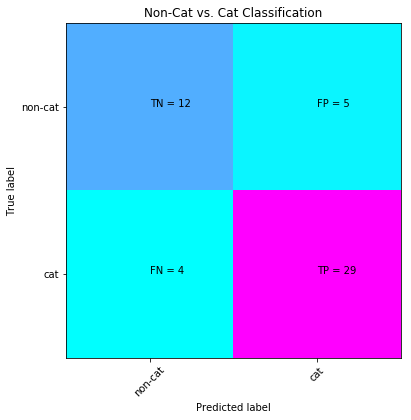

In [8]:
# Plot confusion Matrix
plt.rcParams['figure.figsize'] = (6.0, 7.0)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.cool)
classNames = [classes[0].decode('utf-8'), classes[1].decode('utf-8')]
plt.title('Non-Cat vs. Cat Classification')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

#### Confusion Matrix Interpretation:
**True Positives (TP):** Images that were correctly classified as a "cat" picture, i.e. truly predicted as positive.

In [9]:
# True Positive
TP = cm[1, 1]
print("TP = "+str(TP))

TP = 29


**True Negatives (TN):** Images that were correclty classified as **NOT** a "cat" picture, i.e. truly predicted as negative.

In [10]:
# True Negative
TN = cm[0, 0]
print("TN = "+str(TN))

TN = 12


**False Positives (FP):** Images *incorrectly* classified as a "cat" picture, i.e. falsely predicted as positive.

In [11]:
# False Positive
FP = cm[0, 1]
print("FP = "+str(FP))

FP = 5


**False Negatives (FN):** Images *incorectly* classified as **NOT** a "cat" picture, i.e. falsely predicted as negative.

In [12]:
# False Negative
FN = cm[1, 0]
print("FN = "+str(FN))

FN = 4


#### Insight Derived from the Confusion Matrix:
The Confusion Matrix quadrants can be used to provide additional insight into the classificaiton model's overall performance.

**Classification Accuracy:** Overall, how often did the classifier correctly predict images as a "cat" picture?
>**Note:** The Classification Accuracy calculation should correlate directly to the **Accuracy Score**.

$$ACC = \frac{TP + TN}{TP + TN + FP + FN}$$

In [13]:
# Classification Accuracy
print("Classification Accuracy: {}".format(float((TP + TN) / (TP + TN + FP + FN))))

Classification Accuracy: 0.82


**Classification Error:** Overall, how often did the classifier incorrectly predict predict images as a "cat" picture?

$$Error = \frac{FP + FN}{TP + TN + FP + FN}$$

In [14]:
# Classification Error
print("Classification Error: {}".format(float((FP + FN) / (TP + TN + FP + FN))))

Classification Error: 0.18


**Sensitivity:** When the image is a "cat" picture, how often does the model classify the image correctly, i.e. how "sensitive" is the model to detecting the "cat" picture?
>**Note:** Sesnisitvity is often referred to as the "True Positive Rate (TPR)" or "Recall".

$$TPR = \frac{TP}{TP + FN}$$

In [15]:
# Sensitivity
print("Sensitivity: {}".format(float((TP) / (TP + FN))))

Sensitivity: 0.8787878787878788


**Specificity:** When the image is **NOT** a "cat" picture, how often does the model classify the image correctly, i.e. how "specific" or "selective" is the model to detecting that there is no cat in the "cat" picture?
>**Note:** Specificity is often referred to as the "True Negative Rate (TNR)".

$$TNR = \frac{TN}{TN + FP}$$

In [16]:
# Specificity
print("Specificity: {}".format(float((TN) / (TN + FP))))

Specificity: 0.7058823529411765


**False Positive Rate (FPR):** When the image is **NOT** a "cat" picture, how often does the model classify the image incorrectly?

$$FPR = \frac{FP}{FP + TN}$$

In [17]:
# False Positive Rate
print("False Positive Rate: {}".format(float((FP) / (FP + TN))))

False Positive Rate: 0.29411764705882354


**Precision:** When the image is correclty classified as a "cat" picture, how often is that classificaiton correct?
>**Note:** Precision is often referred to as the "Positive Predictive Value (PPV)".

$$PPV = \frac{TP}{TP + FP}$$

In [18]:
# Precision
print("Precision: {}".format(float((TP) / (TP + FP))))

Precision: 0.8529411764705882


#### Mislabeled Images
Another method for deriving further insight is to view the actual images that were incorrectly classified and hopefully gain visible insight into the features or aspects of the image that added to the model's overall classification error.

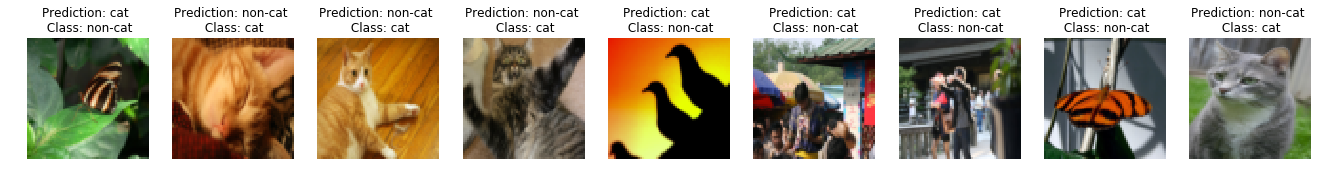

In [19]:
# Print the images that were miskabeled
print_mislabeled_images(NN_parameters, trained_parameters)

By examining some of the test image features that are miss-classified, it can be seen that the model performs poorly on images that have following characteristics:
- Cat body in an unusual position.
- Cat appears against a background of a similar color.
- Unusual cat color and species.
- Camera Angle.
- Brightness and Contrast of the picture.
- Scale variation (cat is very large or small in image).

---
## 3 - Predicting against previously Unseen Data
Finally, the true testiment of wether or not the model will work in production is to test it's predictive capabilities on unseen data. Data that is neither part of the traing set nor the testing set.

#### Previously Unseen Cat Picture: Grumpy Cat
The code cell below shows an example wether or not the trained model will detect if the `grumpy_cat.jpeg` image is actually a "cat" picture.

y = 1
The trained model predicts a "cat" picture.


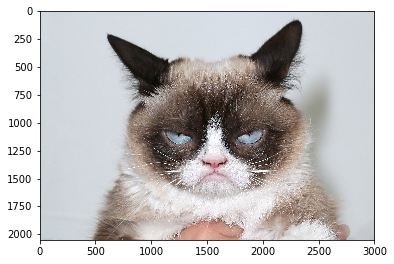

In [20]:
# Display and predict against grumpy cat image
from skimage import transform
my_image = "grumpy_cat.jpeg"
y = [1] # the true class label of the image (1 -> cat)
fname = "images/" + my_image
# Read the image
img = plt.imread(fname)
# Pre-process the image
image = transform.resize(img, (num_px, num_px), mode='constant').reshape((num_px * num_px * 3, 1))
# Run the model against the image
my_predicted_image = predict(image, NN_parameters, trained_parameters)
# Plot the final image
plt.rcParams['figure.figsize'] = (6.0, 7.0)
plt.imshow(img);
# Print the results
print ("y = " + str(np.squeeze(my_predicted_image)) + \
       "\nThe trained model predicts a \"" + \
       classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

#### Previously Unseen Non-Cat Picture: Gargouille
The code cell below shows an example of wether or not the trained model will detect if the `gargouille.jpeg` image is a actually **NOT** a "cat" picture.

y = 0
The trained model predicts a "non-cat" picture.


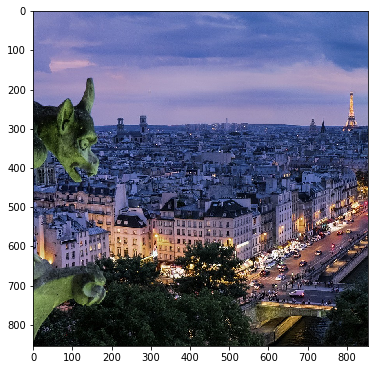

In [21]:
# Display and predict against the gargouille image
my_image = "gargouille.jpeg"
y = [1] # the true class label of the image (1 -> cat)
fname = "images/" + my_image
# Read the image
img = plt.imread(fname)
# Pre-process the image
image = transform.resize(img, (num_px, num_px), mode='constant').reshape((num_px * num_px * 3, 1))
# Run the model against the image
my_predicted_image = predict(image, NN_parameters, trained_parameters)
# Plot the final image
plt.rcParams['figure.figsize'] = (6.0, 7.0)
plt.imshow(img);
# Print the results
print ("y = " + str(np.squeeze(my_predicted_image)) + \
       "\nThe trained model predicts a \"" + \
       classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

---
## Analysis Summary
In summation, the trained model not only detects whether or not the previously unseen images are a "cat" image as well as "non-cat" image, but from the wealth of additional performance metrics, the following overall analysis can be made:

### Pros:
- The model has a relatively high testing *Accuracy* and generalizes well to the unseen data.
- Even though the accuracy could be higher, the model doesn't suffer from overfitting on the testing data.
- From the *Specificity*, *Sensitivity * and *Precision* metrics (metrics to maximize), it can be further seen that the model generalizes well to "cat" images.
- Similarly, from the *False Positive Rate* metric (another metric to maximize), it is evident that the model also generalizes well to "non-cat" images.

### Cons:
- The *Training Results* show the total training time around $49$ hours, which is extremely high.
- The *Training Results* also show that, at least for the first $1500$ epoch's, the model suffers from an **Exploding Gradient** problem.

## Next Steps
So even though the classifier created with the **LNN** framework generalizes well, there is still room for improvement. Future releases of the LNN demo will be improved by leveraging the following techniques:
1. Better initialization of the *Weights* and *Bias* parameters by using [Xavier](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) initialization.
2. Smoothing out the gradient by using better optimizations like [Momentum](http://ufldl.stanford.edu/tutorial/supervised/OptimizationStochasticGradientDescent/) or [Adam](https://arxiv.org/pdf/1412.6980.pdf).
3. Optimizing the training error over fewer iterations with [Mini-batch Gradient Descent](http://www.bogotobogo.com/python/scikit-learn/scikit-learn_batch-gradient-descent-versus-stochastic-gradient-descent.php) **or** in parallel by incorporating a *Model Parallelism* paradigm like [Downpour SGD](http://ecmlpkdd2017.ijs.si/papers/paperID136.pdf).